# EMI mechanical model – part 2

The EMI framework, as presented in the previous notebook, is in particular well-suited for differentiating between intracellular and extracellular subprocesses, and studying how changes in one subdomain affects the dynamics in the other subdomain, as well as the tissue block as a whole.

In this section, we'll try to connect this with some physiologically relevant quantities. We will, in particular, focus on _increased contractility_ and on _increased extracellular stiffness_. The first can be coupled to myofilament dynamics, which e.g. can be modeled using the Rice model. We'll start by simply using a scaling factor, and study the impact of decreased and increased contractility. For those interested, we'll also present a bonus task for getting these values from the Rice model. Next, we'll focus on changes in the stiffness of the extracellular subdomain. Increased stiffness of the extracellular subdomain is a known effect of instritial fibrosis, which makes it increasingly harder for the cells to contract.

## Increased contractility

We'll need a similar setup as in the previous notebook; let's collect the imports and define an instance of the EMIModel here:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import fenics as f
import emimechanicalmodel as emi_m

f.set_log_level(30)        # less verbatim output from the Newton solver compared to default

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
mesh_file = "tile_connected_10p0.h5"
mesh, volumes = emi_m.load_mesh(mesh_file)

emimodel = emi_m.EMIModel(
            mesh,
            volumes,
            experiment="contraction",
            material_model="guccione",
            active_model="active_stress",
            compressibility_model="nearly_incompressible",
        )

Mesh and subdomains loaded successfully.
Number of nodes: 335, number of elements: 1364
length=102.0, width=20.0, height=24.0


Next let's read in the active tension transient:

In [9]:
time = np.linspace(0, 500, 125)              # 500 ms with 125 steps
active_force = np.load("active_precomputed.npy")
active_precomputed = active_force[0:500:4]   # same dimension as time

Like in the previous notebook, we will track intracellular fiber direction strain and stress values (but let's focus on these rather than extending this to the other directions):

In [10]:
fiber_dir_strain_i = np.zeros_like(active_precomputed)
fiber_dir_stress_i = np.zeros_like(active_precomputed) 
subdomain_id = 1         # intracellular subdomain

for step, a_str in enumerate(active_precomputed):
    emimodel.update_active_fn(a_str)
    emimodel.solve()
    
    fiber_dir_strain_i[step] = \
        emimodel.evaluate_subdomain_strain_fibre_dir(subdomain_id)
    fiber_dir_stress_i[step] = \
        emimodel.evaluate_subdomain_stress_fibre_dir(subdomain_id)


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  149cf7bbfffe157a560d262289a63cfe2d1e7244
*** -------------------------------------------------------------------------


... which we of course can plot, like before:

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

axes[0].plot(time, fiber_dir_strain_i)
axes[1].plot(time, fiber_dir_stress_i)

axes[0].set_xlabel("Time (ms)")
axes[1].set_xlabel("Time (ms)")
axes[0].set_ylabel("Strain (-)")
axes[1].set_ylabel("Stress (kPa)")

axes[0].set_title(r"Fiber direction strain, over $\Omega_i$")
axes[1].set_title(r"Fiber direction stress, over $\Omega_i$")

plt.show()

We can scale the contractility up and down by changing the magnitude, i.e., scale all of the active_precomputed values. The scaled transients may look like this:

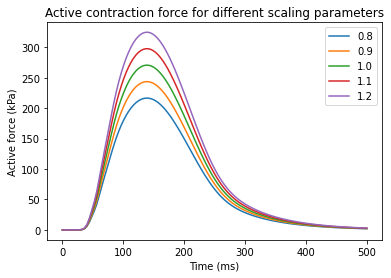

In [11]:
scaling_factors = [0.8, 0.9, 1.0, 1.1, 1.2]

for scaling_factor in scaling_factors:
    scaled_values = scaling_factor*active_precomputed
    plt.plot(time, scaled_values)
    plt.xlabel("Time (ms)")
    plt.ylabel("Active force (kPa)")
plt.legend(scaling_factors)
plt.title("Active contraction force for different scaling parameters")
plt.show()

### Exercise: Decreasing and increasing contractility

Use the scaled active transient values to run the simulations. For each scaling factor, define an array <code>scaled_values</code> as above, and run the forward model with this as input. Keep track of $\overline{\sigma_{ff}}$ and $\overline{E_{ff}}$ integrated over the intracellular subdomain. Plot the stress and strain curves together to see how increased contractilitiy changes the dynamics.

In [ ]:
# write code here

### Bonus exercise: Decreasing and increasing the calcium amplitude

The scaling factors above can be seen as a proxy of an increase in other factors. To be more specific, we can also run the Rice model and change the parameters there directly – then use this as an input to our model. For example, changing the calcium amplitude will also affect the force generated.

1. Run the code below for calculating the force generated by the Rice model, using standard parameters.
2. Next, change the calcium parameter and investigate how decreased and increased calcium amplitude affects the force.
3. Finally, couple in the EMI model and give the force generated to run the contraction of the cell

Note that we only run the model up to 500 ms, while in the myofilament notebook use up to 1000 ms. We could also do 1000 ms, but not much would change in the last part as that is the "resting" phase for the cells.

In [10]:
def run_forward_emi_simulation(emimodel, active_values):
    fiber_dir_strain_i = np.zeros_like(active_values)
    fiber_dir_stress_i = np.zeros_like(active_values) 
    subdomain_id = 1         # intracellular subdomain

    for step, a_str in enumerate(active_values):
        emimodel.update_active_fn(a_str)
        emimodel.solve()
    
        fiber_dir_strain_i[step] = \
            emimodel.evaluate_subdomain_strain_fibre_dir(subdomain_id)
        fiber_dir_stress_i[step] = \
            emimodel.evaluate_subdomain_stress_fibre_dir(subdomain_id)

    return fiber_dir_strain_i, fiber_dir_stress_i


In [ ]:
import rice_model_2008 as rice
from scipy.integrate import odeint

# this is predefined if you have run all the code above, but for the
# rice model part to work independently you can also comment this in:
time = np.linspace(0,200,50)

#scaling_factors = [1]
scaling_factors = [0.8, 0.9, 1.0, 1.1, 1.2]

scaling_factor_force = 2000

for scaling_factor in scaling_factors:
    p = rice.init_parameter_values(Ca_amplitude = scaling_factor*1.45)
    force_ind = rice.monitor_indices("active")

    init = rice.init_state_values()
    states = odeint(rice.rhs,init,time,(p,))

    force = []
    for tn, sn in zip(time,states):
        m = rice.monitor(sn,tn,p)
        force.append(scaling_factor_force*m[force_ind])

    strain, stress = run_forward_emi_simulation(emimodel, force)
    plt.plot(time, strain)
    
    emimodel.state.vector()[:] = 0
    
plt.show()

## Increased matrix stiffness

A quick recap from the previous notebook: The relation between stress and strain in any given material is given by a strain energy function $\Psi$. In our EMI model we have two strain energy functions, given by respectively

$$ \Psi_i = C_i (e^{Q_i} - 1) + \kappa_i (J \ln J - J + 1) \quad \qquad \mathbf{x} \in \Omega_{i} $$

and

$$ \Psi_e = C_e (e^{Q_e} - 1) + \kappa_e (J \ln J - J + 1) \quad \qquad \mathbf{x} \in \Omega_{i} $$

where $C_i$ and $C_e$ are material parameters. There are also material parameters connected to the exponential terms - with material parameters $b_{i, f}$, $b_{i, t}$, $b_{i, ft}$, and $b_{e}$, in additional to the compressibility parameters $\kappa_i$ and $\kappa_e$.

In general, all of these can be altered by giving them in as a dictionary:

In [12]:
material_parameters = {
    "C_i" : 4,
    "C_e" : 2,
    "b_if" : 40,
    "b_it" : 5,
    "b_ift" : 5,
    "b_e" : 10}

emimodel = emi_m.EMIModel(
            mesh,
            volumes,
            experiment="contraction",
            material_model="guccione",
            material_parameters=material_parameters,
            active_model="active_stress",
            compressibility_model="nearly_incompressible",
        )

length=102.0, width=20.0, height=24.0


The extracellular stiffness can be altered using the "C_i" parameter, so for our purposes we can simplify this a little and just write:

In [ ]:
material_parameters = {
    "C_e" : 4,
    }

emimodel = emi_m.EMIModel(
            mesh,
            volumes,
            experiment="contraction",
            material_model="guccione",
            material_parameters=material_parameters,
            active_model="active_stress",
            compressibility_model="nearly_incompressible",
        )

Next, we follow the normal procedure and track fiber direction strain and stress values:

In [39]:
fiber_dir_strain_i = np.zeros_like(active_precomputed)
fiber_dir_stress_i = np.zeros_like(active_precomputed) 
subdomain_id = 1         # intracellular subdomain

for step, a_str in enumerate(active_precomputed):
    emimodel.update_active_fn(a_str)
    emimodel.solve()
    
    fiber_dir_strain_i[step] = \
        emimodel.evaluate_subdomain_strain_fibre_dir(subdomain_id)
    fiber_dir_stress_i[step] = \
        emimodel.evaluate_subdomain_stress_fibre_dir(subdomain_id)


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


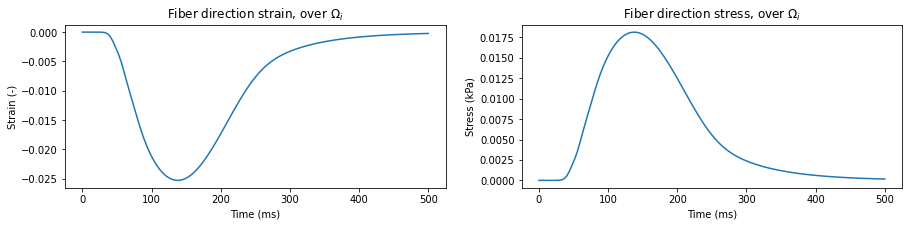

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

axes[0].plot(time, fiber_dir_strain_i)
axes[1].plot(time, fiber_dir_stress_i)

axes[0].set_xlabel("Time (ms)")
axes[1].set_xlabel("Time (ms)")
axes[0].set_ylabel("Strain (-)")
axes[1].set_ylabel("Stress (kPa)")

axes[0].set_title(r"Fiber direction strain, over $\Omega_i$")
axes[1].set_title(r"Fiber direction stress, over $\Omega_i$")

plt.show()

### Exercise: Scale the ECM stiffness

1. Change the $C_e$ parameter by scaling it up and down (use the same range; $[0.8, 0.9, 1.0, 1.1, 1.2]$), and run a forward simulation for each scaled parameter. Note that you here should have an opposite effect; lower stiffness values will make it easier for the cell to contract with the same contraction force.

2. Plot the resulting stress and strain values together. Compare to the plot for increased contractility. Can you describe the differences?

In [43]:
# write code here

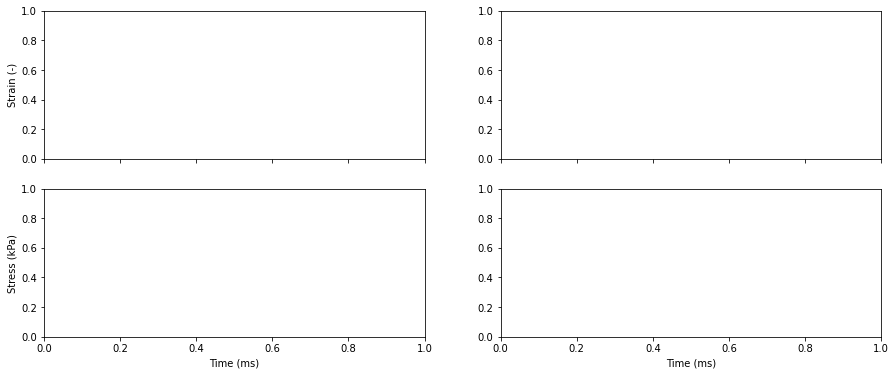

interactive(children=(FloatSlider(value=1.0, description='ca_scale', max=1.22, min=0.8, step=0.04), FloatSlide…